In [ ]:
from transformers import get_linear_schedule_with_warmup, AdamW, BertTokenizer
from sklearn.utils.class_weight import compute_class_weight
from sklearn.model_selection import train_test_split
import torch.nn as nn
import numpy as np
import torch
import pandas as pd
from torch.utils.data import DataLoader, Dataset
from model_2_head import HierarchicalSentimentClassifier
import copy

df = pd.read_csv('data/processed_data.csv')

df["neutral"] = df["rating_star"].apply(lambda x: 1 if x == 1 else 0)
df["sentiment"] = df["rating_star"].apply(lambda x: 1 if x == 2 else 0)

tokenizer = BertTokenizer.from_pretrained("bert-base-multilingual-uncased")

train_texts, val_texts, train_neutral, val_neutral, train_sentiment, val_sentiment = train_test_split(
    df["comment"].tolist(),
    df["neutral"].tolist(),
    df["sentiment"].tolist(),
    test_size=0.2,
    random_state=42
)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

class CustomDataset(Dataset):
    def __init__(self, texts, neutral_labels, sentiment_labels, tokenizer, max_length=128, device="cuda" if torch.cuda.is_available() else "cpu"):
        self.texts = texts
        self.neutral_labels = neutral_labels
        self.sentiment_labels = sentiment_labels
        self.tokenizer = tokenizer
        self.max_length = max_length
        self.device = device

    def __len__(self):
        return len(self.texts)
    
    def __getitem__(self, idx):
        text = self.texts[idx]
        neutral_label = self.neutral_labels[idx]
        sentiment_label = self.sentiment_labels[idx]

        encoding = self.tokenizer(
            text,
            padding='max_length',
            truncation=True,
            max_length=self.max_length,
            return_tensors="pt"
        )

        return {
            'input_ids': encoding['input_ids'].squeeze(0).to(self.device),
            'attention_mask': encoding['attention_mask'].squeeze(0).to(self.device),
            'neutral_label': torch.tensor(neutral_label, dtype=torch.float).to(self.device),
            'sentiment_label': torch.tensor(sentiment_label, dtype=torch.long).to(self.device)
        }

train_dataset = CustomDataset(train_texts, train_neutral, train_sentiment, tokenizer, device=device)
val_dataset = CustomDataset(val_texts, val_neutral, val_sentiment, tokenizer, device=device)

train_dataloader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_dataloader = DataLoader(val_dataset, batch_size=32, shuffle=False)

class_weights = compute_class_weight(
    class_weight="balanced", classes=np.unique(train_sentiment), y=train_sentiment
)
class_weights = torch.tensor(class_weights, dtype=torch.float).to(device)

model = HierarchicalSentimentClassifier()
model.to(device)

neutral_loss_fn = nn.BCEWithLogitsLoss()
sentiment_loss_fn = nn.CrossEntropyLoss(weight=class_weights)

min_delta = 0.001
patience = 3
stage1_num_epochs = 3
stage2_num_epochs = 4

optimizer = AdamW(model.parameters(), lr=2e-5)
total_steps = len(train_dataloader) * stage1_num_epochs
scheduler = get_linear_schedule_with_warmup(optimizer, num_warmup_steps=0, num_training_steps=total_steps)

for param in model.bert.encoder.layer.parameters():
    param.requires_grad = False

best_loss = float('inf')
counter = 0
best_model_wts = copy.deepcopy(model.state_dict())

for epoch in range(stage1_num_epochs):
    model.train()
    epoch_loss = 0.0

    for batch in train_dataloader:
        neutral_logit, sentiment_logits = model(batch["input_ids"], attention_mask=batch["attention_mask"])

        loss_neutral = neutral_loss_fn(neutral_logit, batch["neutral_label"])
        loss_sentiment = sentiment_loss_fn(sentiment_logits, batch["sentiment_label"])
        loss = loss_neutral + loss_sentiment

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        scheduler.step()

        epoch_loss += loss.item()

    avg_loss = epoch_loss / len(train_dataloader)

    model.eval()
    val_loss = 0.0
    with torch.no_grad():
        for batch in val_dataloader:
            neutral_logit, sentiment_logits = model(batch["input_ids"], attention_mask=batch["attention_mask"])
            loss_neutral = neutral_loss_fn(neutral_logit, batch["neutral_label"])
            loss_sentiment = sentiment_loss_fn(sentiment_logits, batch["sentiment_label"])
            val_loss += (loss_neutral + loss_sentiment).item()
    avg_val_loss = val_loss / len(val_dataloader)
    print(f"Stage 1, Epoch [{epoch+1}/{stage1_num_epochs}], Train Loss: {avg_loss:.4f}, Val Loss: {avg_val_loss:.4f}")

    if avg_val_loss < best_loss - min_delta:
        best_loss = avg_val_loss
        best_model_wts = copy.deepcopy(model.state_dict())
        counter = 0
    else:
        counter += 1
        if counter >= patience:
            print(f"Early stopping at epoch {epoch+1}")
            break

model.load_state_dict(best_model_wts)

for param in model.bert.encoder.layer[-6:].parameters():
    param.requires_grad = True

optimizer = AdamW(model.parameters(), lr=2e-5)
total_steps = len(train_dataloader) * stage2_num_epochs
scheduler = get_linear_schedule_with_warmup(optimizer, num_warmup_steps=0, num_training_steps=total_steps)

best_loss = float('inf')
counter = 0
best_model_wts = copy.deepcopy(model.state_dict())

for epoch in range(stage2_num_epochs):
    model.train()
    epoch_loss = 0.0

    for batch in train_dataloader:
        neutral_logit, sentiment_logits = model(batch["input_ids"], attention_mask=batch["attention_mask"])
        loss_neutral = neutral_loss_fn(neutral_logit, batch["neutral_label"])
        loss_sentiment = sentiment_loss_fn(sentiment_logits, batch["sentiment_label"])
        loss = loss_neutral + loss_sentiment

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        scheduler.step()

        epoch_loss += loss.item()

    avg_loss = epoch_loss / len(train_dataloader)

    model.eval()
    val_loss = 0.0
    with torch.no_grad():
        for batch in val_dataloader:
            neutral_logit, sentiment_logits = model(batch["input_ids"], attention_mask=batch["attention_mask"])
            loss_neutral = neutral_loss_fn(neutral_logit, batch["neutral_label"])
            loss_sentiment = sentiment_loss_fn(sentiment_logits, batch["sentiment_label"])
            val_loss += (loss_neutral + loss_sentiment).item()
    avg_val_loss = val_loss / len(val_dataloader)
    print(f"Stage 2, Epoch [{epoch+1}/{stage2_num_epochs}], Train Loss: {avg_loss:.4f}, Val Loss: {avg_val_loss:.4f}")

    if avg_val_loss < best_loss - min_delta:
        best_loss = avg_val_loss
        best_model_wts = copy.deepcopy(model.state_dict())
        counter = 0
    else:
        counter += 1
        if counter >= patience:
            print(f"Early stopping at epoch {epoch+1}")
            break

model.load_state_dict(best_model_wts)
print("Training Done!")

c:\Users\USER\AppData\Local\Programs\Python\Python312\Lib\site-packages\transformers\optimization.py:640: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


Stage 1, Epoch [1/3], Train Loss: 1.2336, Val Loss: 1.1993
Stage 1, Epoch [2/3], Train Loss: 1.1580, Val Loss: 1.1487
Stage 1, Epoch [3/3], Train Loss: 1.1138, Val Loss: 1.1252
Stage 2, Epoch [1/4], Train Loss: 0.9662, Val Loss: 0.9272
Stage 2, Epoch [2/4], Train Loss: 0.8566, Val Loss: 0.8997
Stage 2, Epoch [3/4], Train Loss: 0.7925, Val Loss: 0.8302
Stage 2, Epoch [4/4], Train Loss: 0.7365, Val Loss: 0.8362
Training Done!


In [15]:
from sklearn.metrics import f1_score, precision_score, recall_score, confusion_matrix

model.eval()

neutral_thresholds = [0.2, 0.3, 0.4, 0.5]
sentiment_thresholds = [0.3, 0.4, 0.5, 0.6]

best_f1 = 0.0
best_config = (None, None)
best_preds = []
best_labels = []

with torch.no_grad():
    for n_thresh in neutral_thresholds:
        for s_thresh in sentiment_thresholds:
            all_preds = []
            all_labels = []

            for batch in val_dataloader:
                input_ids = batch["input_ids"]
                attention_mask = batch["attention_mask"]
                neutral_labels = batch["neutral_label"]
                sentiment_labels = batch["sentiment_label"]

                neutral_logit, sentiment_logits = model(input_ids, attention_mask=attention_mask)

                neutral_probs = torch.sigmoid(neutral_logit)
                sentiment_probs = torch.softmax(sentiment_logits, dim=1)

                for n_prob, s_prob in zip(neutral_probs, sentiment_probs):
                    s_neg = s_prob[0].item()
                    s_pos = s_prob[1].item()

                    if n_prob.item() >= n_thresh:
                        all_preds.append(1)
                    elif s_neg < s_thresh and s_pos < s_thresh:
                        all_preds.append(1)
                    else:
                        all_preds.append(0 if s_neg > s_pos else 2)

                for n_label, s_label in zip(neutral_labels, sentiment_labels):
                    if n_label.item() == 1:
                        all_labels.append(1)
                    else:
                        all_labels.append(0 if s_label.item() == 0 else 2)

            f1 = f1_score(all_labels, all_preds, average="weighted")

            if f1 > best_f1:
                best_f1 = f1
                best_config = (n_thresh, s_thresh)
                best_preds = all_preds.copy()
                best_labels = all_labels.copy()

precision = precision_score(best_labels, best_preds, average="weighted")
recall = recall_score(best_labels, best_preds, average="weighted")
conf_matrix = confusion_matrix(best_labels, best_preds)
accuracy = sum([p == l for p, l in zip(best_preds, best_labels)]) / len(best_labels)

print(f"Best Config => Neutral Threshold: {best_config[0]}, Sentiment Threshold: {best_config[1]}")
print(f"Final Accuracy: {accuracy:.4f}")
print(f"Final F1 Score: {best_f1:.4f}")
print(f"Final Precision: {precision:.4f}")
print(f"Final Recall: {recall:.4f}")
print("\nConfusion Matrix (Pred rows x True cols):")
print(conf_matrix)

Best Config => Neutral Threshold: 0.3, Sentiment Threshold: 0.3
Final Accuracy: 0.6814
Final F1 Score: 0.6902
Final Precision: 0.7081
Final Recall: 0.6814

Confusion Matrix (Pred rows x True cols):
[[469 163  29]
 [129 229  57]
 [110 119 600]]


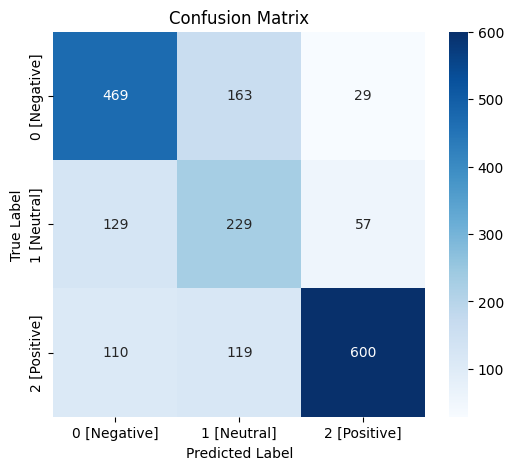

In [13]:
import matplotlib.pyplot as plt
import seaborn as sns

class_labels = ["0 [Negative]", "1 [Neutral]", "2 [Positive]"]

plt.figure(figsize=(6, 5))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=class_labels, yticklabels=class_labels)

plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix")
plt.show()